# My Example Solution for DeepAR

### Imporinting Libraries


In [71]:
import pandas as pd
import matplotlib.pyplot as plt

### Data Loading
 


In [72]:
df_train = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
df_oil = pd.read_csv('data/oil.csv', index_col=0, parse_dates=True)
df_stores = pd.read_csv('data/stores.csv', index_col=0, parse_dates=True)
df_test = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)
df_transactions = pd.read_csv('data/transactions.csv', index_col=0, parse_dates=True)
df_holiday = pd.read_csv('data/holidays_events.csv', index_col=0, parse_dates=True)

/tmp/ipykernel_132477/917830957.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_132477/917830957.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_stores = pd.read_csv('data/stores.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_132477/917830957.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)


### Data Preprocessing
 


In [73]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)

In [74]:
df_train

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0
2013-01-01,1,BABY CARE,0.000,0
2013-01-01,1,BEAUTY,0.000,0
2013-01-01,1,BEVERAGES,0.000,0
2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0
2017-08-15,9,PREPARED FOODS,154.553,1
2017-08-15,9,PRODUCE,2419.729,148


In [75]:
df_train.describe()

,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00
std,1.558579e+01,1.101998e+03,1.221888e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02


In [76]:
df_train.shape

(3000888, 4)

In [77]:
df_stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [78]:
df_stores.shape

(54, 4)

### Data Merging

In [79]:
df_combined = df_train.merge(df_stores,how='left', left_on='store_nbr', right_index=True)

In [80]:
df_combined.shape

(3000888, 8)

In [81]:
df_combined.head()

,store_nbr,family,sales,onpromotion,city,state,type,cluster
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [82]:
df_combined.describe()

,store_nbr,sales,onpromotion,cluster
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00
std,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01
max,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01


In [83]:
df_oil

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [84]:
df_oil.index = pd.to_datetime(df_oil.index)


In [85]:
df_combined_oil = df_combined.merge(df_oil, how='left', left_index=True, right_index=True)

In [86]:
df_combined_oil.head()

,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [87]:
merged_df = df_combined_oil.merge(
    df_transactions,
    how='left',
    left_on=['date', 'store_nbr'],
    right_on=['date', 'store_nbr']
)

In [88]:
merged_df

,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0
2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0
2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0


#### //// For this moment merged 
#### train-oil-transaction-stores   ---> -holiday

In [89]:
df_holiday

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [90]:
merged_df_final = merged_df.merge(df_holiday, how='left', left_index=True, right_index=True)

In [91]:
merged_df_final

,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred
date,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [92]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int64  
 1   family        object 
 2   sales         float64
 3   onpromotion   int64  
 4   city          object 
 5   state         object 
 6   type_x        object 
 7   cluster       int64  
 8   dcoilwtico    float64
 9   transactions  float64
 10  type_y        object 
 11  locale        object 
 12  locale_name   object 
 13  description   object 
 14  transferred   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 372.8+ MB


In [93]:
merged_df_final.isna().sum()
merged_df_final.fillna(0, inplace=True)

In [94]:
categorical = merged_df_final.select_dtypes(include=['object']).columns
for col in categorical:
    val = merged_df_final[col].nunique()
    print(f"Column {col} has {val} unique values.")

Column family has 33 unique values.
Column city has 22 unique values.
Column state has 16 unique values.
Column type_x has 5 unique values.
Column type_y has 7 unique values.
Column locale has 4 unique values.
Column locale_name has 25 unique values.
Column description has 102 unique values.
Column transferred has 2 unique values.


In [95]:
exp = pd.get_dummies(merged_df_final)

In [96]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Columns: 222 entries, store_nbr to transferred_True
dtypes: bool(216), float64(3), int64(3)
memory usage: 792.3 MB


In [97]:
exp.columns


Index(['store_nbr', 'sales', 'onpromotion', 'cluster', 'dcoilwtico',
       'transactions', 'family_AUTOMOTIVE', 'family_BABY CARE',
       'family_BEAUTY', 'family_BEVERAGES',
       ...
       'description_Terremoto Manabi+8', 'description_Terremoto Manabi+9',
       'description_Traslado Batalla de Pichincha',
       'description_Traslado Fundacion de Guayaquil',
       'description_Traslado Independencia de Guayaquil',
       'description_Traslado Primer Grito de Independencia',
       'description_Traslado Primer dia del ano', 'description_Viernes Santo',
       'transferred_False', 'transferred_True'],
      dtype='object', length=222)

### Visualising

In [98]:
merged_df_final.describe()

,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,4.674603e+01,1.558656e+03
std,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,3.805151e+01,1.036468e+03
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,9.310000e+02
50%,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,4.702000e+01,1.332000e+03
75%,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.153000e+01,1.980000e+03
max,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03


In [99]:
'''
Next
'''
def plot_time_series(df, column, title=None):
    """
    Plots a single column from a DataFrame with a datetime index.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[column])
    plt.title(title if title else f"Time Series of {column}")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

def plot_all_time_series(df, columns=None, max_plots=10):
    """
    Plots all (or selected) columns from a DataFrame with a datetime index.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number', 'bool']).columns
    for i, col in enumerate(columns):
        if i >= max_plots:
            print(f"Only plotting first {max_plots} columns.")
            break
        plot_time_series(df, col)

def plot_all_dfs(dfs, columns_dict=None, max_plots=10):
    """
    Plots all (or selected) columns from multiple DataFrames.
    dfs: dict of {name: DataFrame}
    columns_dict: dict of {name: [columns]} (optional)
    """
    for name, df in dfs.items():
        print(f"\n--- {name} ---")
        cols = columns_dict[name] if columns_dict and name in columns_dict else None
        plot_all_time_series(df, columns=cols, max_plots=max_plots)

### Data Preprocessing
 


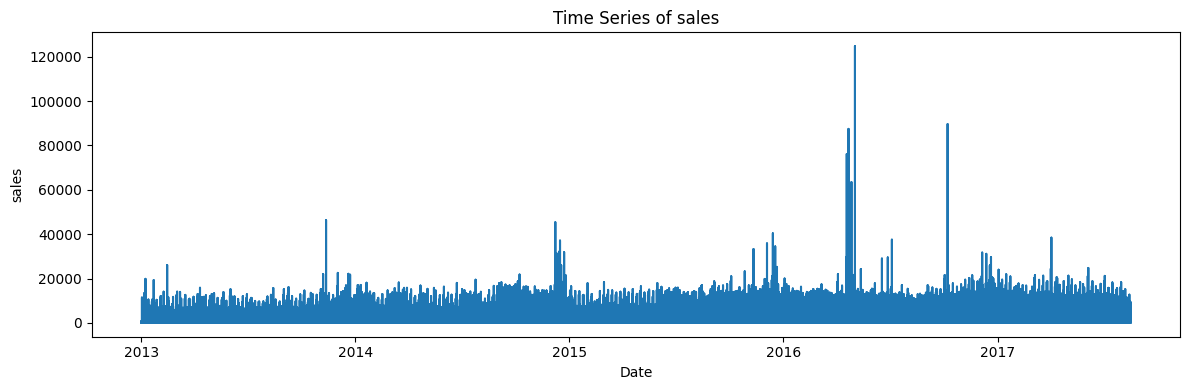

In [101]:
plot_time_series(merged_df_final, 'sales')

### Modeling

### Training


### Testing

